# Improving Pandas performance

## Goals for today
 - Memory usage
     - String types
     - Numeric types


 - Method chaining
     - Filtering data
     - Create new columns
 
## About Dataset

Chicago crime records for the year 2022 from the Chicago Police Department 

Downloaded on 30 Aug 2022 - Has records from Jan 01 to Aug 22 [Data Source](https://data.cityofchicago.org/Public-Safety/Crimes-2022/9hwr-2zxp)


In [1]:
# import the libraries
import pandas as pd
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

# pandas version
pd.__version__

'1.2.2'

In [2]:
# load the data 
df = pd.read_csv('ChicagoCrimes2022.csv',
                 parse_dates=['Date', 'Updated On']
                )

print(df.shape)

df.head()

(143185, 22)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12751203,JF305497,2022-07-04 22:57:00,004XX E 40TH ST,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,...,3.0,38,14,1180017.0,1878243.0,2022,2022-07-24 16:47:33,41.821170,-87.615115,"(41.821170402, -87.615115421)"
1,12756673,JF312128,2022-07-10 11:48:00,039XX W CHICAGO AVE,0430,BATTERY,AGGRAVATED - OTHER DANGEROUS WEAPON,RESTAURANT,False,False,...,37.0,23,04B,1149770.0,1905050.0,2022,2022-07-24 16:47:33,41.895372,-87.725381,"(41.895372283, -87.725380843)"
2,12768448,JF326144,2022-06-24 00:00:00,081XX S GREEN ST,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,APARTMENT,False,False,...,21.0,71,11,1172054.0,1850887.0,2022,2022-07-24 16:47:33,41.746281,-87.645131,"(41.746281377, -87.645130733)"
3,12767303,JF324716,2022-07-17 17:10:00,045XX S DREXEL BLVD,0820,THEFT,$500 AND UNDER,RESIDENCE - PORCH / HALLWAY,False,False,...,4.0,39,06,1183084.0,1875126.0,2022,2022-07-24 16:49:35,41.812546,-87.603961,"(41.812546224, -87.603961332)"
4,12763448,JF320476,2022-07-17 08:25:00,032XX N CLARK ST,0860,THEFT,RETAIL THEFT,DEPARTMENT STORE,False,False,...,44.0,6,06,1169868.0,1921628.0,2022,2022-07-24 16:49:35,41.940449,-87.651082,"(41.94044868, -87.651081589)"


## Memory Usage in pandas

When set to deep, introspects the data deeply and includes object dtypes for system-level memory consumption as well

Below we will see how to gain better memory improvement for two specific dtypes
- object 
- numeric (int/float)

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143185 entries, 0 to 143184
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    143185 non-null  int64         
 1   Case Number           143185 non-null  object        
 2   Date                  143185 non-null  datetime64[ns]
 3   Block                 143185 non-null  object        
 4   IUCR                  143185 non-null  object        
 5   Primary Type          143185 non-null  object        
 6   Description           143185 non-null  object        
 7   Location Description  142801 non-null  object        
 8   Arrest                143185 non-null  bool          
 9   Domestic              143185 non-null  bool          
 10  Beat                  143185 non-null  int64         
 11  District              143185 non-null  int64         
 12  Ward                  143178 non-null  float64       
 13 

#### Object type columns
For string columns with lot of repeated values - converting to the category dtype drastically reduces memory consumption and improves performace 

In [7]:
df.memory_usage(deep='True')

Index                        128
ID                       1145480
Case Number              9307025
Date                     1145480
Block                   10811572
IUCR                     8734285
Primary Type             9651849
Description             10575318
Location Description     9863463
Arrest                    143185
Domestic                  143185
Beat                     1145480
District                 1145480
Ward                     1145480
Community Area           1145480
FBI Code                 8490970
X Coordinate             1145480
Y Coordinate             1145480
Year                     1145480
Updated On               1145480
Latitude                 1145480
Longitude                1145480
Location                12220460
dtype: int64

In [8]:
# memory usage by object column
df['Primary Type'].memory_usage(deep=True, index=False)

9651849

In [9]:
# convert the object dtype to categorical and check the memory usage now
df['Primary Type Cat'] = df['Primary Type'].astype('category')

df['Primary Type Cat'].memory_usage(deep=True, index=False)

146474

In [10]:
# ratio of memory usage before vs now
print(f"we are using {df['Primary Type'].memory_usage(deep=True, index=False)/df['Primary Type Cat'].memory_usage(deep=True, index=False):.2f} times less memory now")

we are using 65.89 times less memory now


##### 10x Speed up!
Using the categorical dtypes doesn't just helps us with memory but also with runtime performance

Below are two simple examples

In [11]:
%%timeit 
df['Primary Type'].value_counts()

36.4 ms ± 8.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit 
df['Primary Type Cat'].value_counts()

3.09 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit 
df[df['Primary Type'] == 'THEFT']

39.4 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit 
df[df['Primary Type Cat'] == 'THEFT']

26.3 ms ± 9.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
# why category dtype needs less memory? - stores a integer mapping for each category - encoding
df['Primary Type Cat'].cat.codes

0          5
1          2
2          8
3         29
4         29
          ..
143180     3
143181    29
143182    16
143183    22
143184    29
Length: 143185, dtype: int8

### Numeric dtypes 
1) Nullable Integers:

When a record is missing for a integer type column - Pandas stores the entire column as float64

Just to be safe, becasue it isn't sure if the missing values has decimal points or not 

[Nullable Integer](https://pandas.pydata.org/docs/user_guide/integer_na.html) - solves the problem of int64 columns chnagng to float64 when NaNs are introduced. This allows for int64 to have null values. The dtype is pd.Int64Dtype() or 'Int64'

[Convert Dtypes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.convert_dtypes.html) - Does this automaticall for every column - converts to the best dtype which supports pd.NA 

2) Downcasting Numeric columns:

[Downcast/Upcast](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html) - pd.to_numeric(s, downcast="integer")

#### Downcasting example 


In [16]:
# by default allocates lot of memory for each col
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143185 entries, 0 to 143184
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    143185 non-null  int64         
 1   Case Number           143185 non-null  object        
 2   Date                  143185 non-null  datetime64[ns]
 3   Block                 143185 non-null  object        
 4   IUCR                  143185 non-null  object        
 5   Primary Type          143185 non-null  object        
 6   Description           143185 non-null  object        
 7   Location Description  142801 non-null  object        
 8   Arrest                143185 non-null  bool          
 9   Domestic              143185 non-null  bool          
 10  Beat                  143185 non-null  int64         
 11  District              143185 non-null  int64         
 12  Ward                  143178 non-null  float64       
 13 

In [18]:
df.Beat

0          214
1         1112
2          613
3          222
4         1924
          ... 
143180     612
143181    1622
143182     632
143183     523
143184    1834
Name: Beat, Length: 143185, dtype: int64

In [19]:
df.Beat.describe()
# df.Beat.astype('int32').memory_usage()

count    143185.000000
mean       1146.725509
std         708.580486
min         111.000000
25%         532.000000
50%        1031.000000
75%        1724.000000
max        2535.000000
Name: Beat, dtype: float64

In [22]:
np.iinfo(np.int16)

iinfo(min=-32768, max=32767, dtype=int16)

In [23]:
np.finfo(np.float16)

finfo(resolution=0.001, min=-6.55040e+04, max=6.55040e+04, dtype=float16)

In [24]:
# original memory usage 
print(f"Original memory usage - {df['Beat'].memory_usage()} bytes")
df['Beat']

Original memory usage - 1145608 bytes


0          214
1         1112
2          613
3          222
4         1924
          ... 
143180     612
143181    1622
143182     632
143183     523
143184    1834
Name: Beat, Length: 143185, dtype: int64

In [25]:
# using the numeric downcast feature to reduce the memory usage of a column
print(f"New memory usage - {pd.to_numeric(df['Beat'], downcast='integer').memory_usage()} bytes")

pd.to_numeric(df['Beat'], downcast="integer")

New memory usage - 286498 bytes


0          214
1         1112
2          613
3          222
4         1924
          ... 
143180     612
143181    1622
143182     632
143183     523
143184    1834
Name: Beat, Length: 143185, dtype: int16

### Nullable Integers

In [26]:
df['X Coordinate']

0         1180017.0
1         1149770.0
2         1172054.0
3         1183084.0
4         1169868.0
            ...    
143180    1170307.0
143181    1137865.0
143182    1178680.0
143183    1175664.0
143184    1179089.0
Name: X Coordinate, Length: 143185, dtype: float64

In [27]:
# just to compare the toal memory savings lets
# reload the dataframe with the best dtype possible 

# Nullable int example
dtypes = {'Beat': 'int16',
          'District': 'int8',
          'Community Area':'int8',
          'Year':'int16',
          'Block':'category',
          'IUCR':'category',
          'Primary Type':'category',
          'Description':'category',
          'Location Description':'category',
          'FBI Code':'category',
          'X Coordinate':pd.Int32Dtype(),
          'Y Coordinate':'Int32',
          'Latitude':'float16',
          'Longitude':'float16'
          
         }

df_mem = pd.read_csv('ChicagoCrimes2022.csv',
                 parse_dates=['Date', 'Updated On'],
                 dtype=dtypes
                )

df_mem.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143185 entries, 0 to 143184
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    143185 non-null  int64         
 1   Case Number           143185 non-null  object        
 2   Date                  143185 non-null  datetime64[ns]
 3   Block                 143185 non-null  category      
 4   IUCR                  143185 non-null  category      
 5   Primary Type          143185 non-null  category      
 6   Description           143185 non-null  category      
 7   Location Description  142801 non-null  category      
 8   Arrest                143185 non-null  bool          
 9   Domestic              143185 non-null  bool          
 10  Beat                  143185 non-null  int16         
 11  District              143185 non-null  int8          
 12  Ward                  143178 non-null  float64       
 13 

## Side effects of using categorical dtype

Using category dtype saves/improves memory/performace. But its very fragile and it can be a huge pain if not used appropriately. 

some scenarios where it gets annoying:
- when joining with other dataframes - if the categories doesnt match exactly in both dfs or if one is category and other is object 
- when renaming/modifying categories 
- when doining group by 


#### renaming/modifying categories 

In [31]:
%%timeit
# df['Primary Type']

df['Primary Type'].str.title()

203 ms ± 71.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%%timeit
df_mem['Primary Type'].str.title()

19 ms ± 5.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
df_mem['Primary Type'].str.title().memory_usage(deep='True')

9651977

In [36]:
# from above cells you can notice dtype changed to object agian 
# workaround for this is to modify the categories instead of the values 
# also notice this is much faster than both the ways we tried above

df_mem['Primary Type'].cat.rename_categories(str.title)

%timeit df_mem['Primary Type'].cat.rename_categories(str.title)

646 µs ± 100 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Group by

In [37]:
# normal group by with objects
df.groupby(['Primary Type', 'Description'])['Case Number'].count().reset_index()

,Primary Type,Description,Case Number
0,ARSON,AGGRAVATED,20
1,ARSON,ATTEMPT ARSON,25
2,ARSON,BY EXPLOSIVE,7
3,ARSON,BY FIRE,199
4,ARSON,POSSESSION - CHEMICAL / DRY-ICE DEVICE,1
...,...,...,...
281,WEAPONS VIOLATION,UNLAWFUL SALE - HANDGUN,1
282,WEAPONS VIOLATION,UNLAWFUL USE - HANDGUN,191
283,WEAPONS VIOLATION,UNLAWFUL USE - OTHER DANGEROUS WEAPON,43
284,WEAPONS VIOLATION,UNLAWFUL USE - OTHER FIREARM,230


In [38]:
# group by with categorical 
df_mem.groupby(['Primary Type', 'Description'])['Case Number'].count().reset_index()

,Primary Type,Description,Case Number
0,ARSON,$500 AND UNDER,0
1,ARSON,ABUSE / NEGLECT - CARE FACILITY,0
2,ARSON,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",0
3,ARSON,"AGG. PROTECTED EMPLOYEE - HANDS, FISTS, FEET, ...",0
4,ARSON,AGGRAVATED,20
...,...,...,...
8272,PUBLIC INDECENCY,POSSESS - HEROIN (BLACK TAR),0
8273,PUBLIC INDECENCY,SEXUAL RELATIONS IN FAMILY,0
8274,PUBLIC INDECENCY,CRIMINAL DRUG CONSPIRACY,0
8275,PUBLIC INDECENCY,MANUFACTURE / DELIVER - BARBITURATES,0


In [39]:
# workaround - use observed=True in group by 

df_mem.groupby(['Primary Type', 'Description'], observed=True)['Case Number'].count().reset_index()

,Primary Type,Description,Case Number
0,CRIMINAL DAMAGE,TO PROPERTY,7779
1,CRIMINAL DAMAGE,TO VEHICLE,7884
2,CRIMINAL DAMAGE,CRIMINAL DEFACEMENT,248
3,CRIMINAL DAMAGE,TO CITY OF CHICAGO PROPERTY,215
4,CRIMINAL DAMAGE,TO STATE SUPPORTED PROPERTY,36
...,...,...,...
281,HUMAN TRAFFICKING,COMMERCIAL SEX ACTS,10
282,HUMAN TRAFFICKING,INVOLUNTARY SERVITUDE,4
283,OTHER NARCOTIC VIOLATION,INTOXICATING COMPOUNDS,2
284,NON-CRIMINAL,CONCEALED CARRY LICENSE REVOCATION,2


## Method Chaining

Very similar to pipe %>% usage in tidyverse packages in R 


In [ ]:
# normally i'm used to writing snippets like this
df.groupby(['Primary Type', 'Description'])['Case Number'].count().reset_index()

In [41]:
# better readability 
(df
 .groupby(['Primary Type', 'Description'])['Case Number']
 .count()
 .reset_index()
)

,Primary Type,Description,Case Number
0,ARSON,AGGRAVATED,20
1,ARSON,ATTEMPT ARSON,25
2,ARSON,BY EXPLOSIVE,7
3,ARSON,BY FIRE,199
4,ARSON,POSSESSION - CHEMICAL / DRY-ICE DEVICE,1
...,...,...,...
281,WEAPONS VIOLATION,UNLAWFUL SALE - HANDGUN,1
282,WEAPONS VIOLATION,UNLAWFUL USE - HANDGUN,191
283,WEAPONS VIOLATION,UNLAWFUL USE - OTHER DANGEROUS WEAPON,43
284,WEAPONS VIOLATION,UNLAWFUL USE - OTHER FIREARM,230


### Number of Arrests by Month 
Lets compare my normal workflow with chaining 


In [42]:
# %%timeit

# my typical workflow 

# filter for arrests 
df_arrests = df[df['Arrest']==True]

# extract month from Date 
df_arrests['Month'] = df_arrests['Date'].dt.strftime('%Y-%m')

# dropna
df_arrests.dropna(inplace=True)

df_arrests.groupby(['Month'])['Arrest'].sum()

<ipython-input-42-37c7fb6f2c61>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arrests['Month'] = df_arrests['Date'].dt.strftime('%Y-%m')
<ipython-input-42-37c7fb6f2c61>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arrests.dropna(inplace=True)


Month
2022-01    1706
2022-02    2067
2022-03    2181
2022-04    2282
2022-05    2694
2022-06    2352
2022-07    2177
2022-08    1449
Name: Arrest, dtype: int64

In [48]:
# %%timeit

# using chains

(df
 .query('Arrest == True')
 .assign(Month = lambda row: row['Date'].dt.strftime('%Y-%m'))
 .dropna()
 .groupby(['Month'])
 ['Arrest']
 .sum()
)


Month
2022-01    1706
2022-02    2067
2022-03    2181
2022-04    2282
2022-05    2694
2022-06    2352
2022-07    2177
2022-08    1449
Name: Arrest, dtype: int64

### Things to note on chaining 
- inplace is not saving us any memory ([Dropna implementation](https://github.com/pandas-dev/pandas/blob/v1.4.4/pandas/core/frame.py#L5882-L6037))
- most useful during the initial load and during clean up of data steps 
- chaining makes it super easy to follow the code 
- reduces unncessary global variable assignments 
- easy to debug - just comment out the line 

#### query vs filtering 

- query is easy to read 
- read that query slightly performs better in large datsets otherwise not much difference 
- no need to repeat the column names multiple times in the filter mask 

In [49]:
# filtering for wards between 10 and 20 
df[(df['Ward']>10) & (df['Ward']<20)].head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Primary Type Cat
6,12763692,JF320639,2022-07-17 02:00:00,008XX W 59TH ST,0325,ROBBERY,VEHICULAR HIJACKING,GAS STATION,False,False,...,68,03,1171833.0,1865730.0,2022,2022-07-24 16:49:35,41.787017,-87.645506,"(41.78701723, -87.645505595)",ROBBERY
7,12769273,JF327430,2022-03-01 11:00:00,080XX S DAMEN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,71,11,1164430.0,1851162.0,2022,2022-07-24 16:47:33,41.747200,-87.673059,"(41.747199949, -87.673059114)",DECEPTIVE PRACTICE


In [50]:
# using query to filters for wards btw 10 and 20
df.query("10<Ward<20").head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Primary Type Cat
6,12763692,JF320639,2022-07-17 02:00:00,008XX W 59TH ST,0325,ROBBERY,VEHICULAR HIJACKING,GAS STATION,False,False,...,68,03,1171833.0,1865730.0,2022,2022-07-24 16:49:35,41.787017,-87.645506,"(41.78701723, -87.645505595)",ROBBERY
7,12769273,JF327430,2022-03-01 11:00:00,080XX S DAMEN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,71,11,1164430.0,1851162.0,2022,2022-07-24 16:47:33,41.747200,-87.673059,"(41.747199949, -87.673059114)",DECEPTIVE PRACTICE


### Using pipe function 
- pipe can be used to include any user defined methods in the chains 


Get the percentage of crimes by hour for in each month

In [59]:
def add_hour_month_column(df_):
    '''
    Adds the hour and month using the date column 
    and returns the dataframe
    '''
    
    df_['Month'] = df_['Date'].dt.month
    df_['Hour'] = df_['Date'].dt.hour
    
    return df_

def percent_of_total(df_):
    '''
    Returns the dataframe with percent of total by column 
    '''
    
    return df_.apply(lambda x: x/x.sum(), axis=0)

In [67]:
cols = ['Month', 'Hour', 'ID']

(df
 .pipe(add_hour_month_column)
 [cols]
 .groupby(['Hour', 'Month'])
 .agg(Count=('ID', 'count'))
 .unstack()
 .pipe(percent_of_total)
 .style.background_gradient(axis=1)
)


# style.background_gradient(axis=0) 

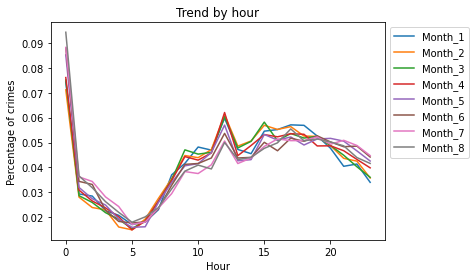

In [65]:
# replicating same plot with clean axes names, legend etc. 

cols = ['Month', 'Hour', 'ID']

(df
 .pipe(add_hour_month_column)
 [cols]
 .astype({'Month': 'category', 'Hour':'category'})
 .groupby(['Hour', 'Month'])
 .agg(Count=('ID', 'count'))
 .unstack()
 .add_prefix('Month_')
 .pipe(lambda piv: piv.set_axis([col[1] for col in piv.columns], axis=1))
 .pipe(percent_of_total)
 .plot(title='Trend by hour', ylabel='Percentage of crimes' )
 .legend(bbox_to_anchor=(1, 1))
)

In [75]:
point_of_interest = []

streets = ['04xx w van buren st', '03xx s canal st', '04xx w jackson blvd', '04xx w adams st', '03xx s riverside plz']
df.Block[df.Block.str.lower().str.contains('|'.join(streets))].value_counts()

004XX W VAN BUREN ST     4
003XX S RIVERSIDE PLZ    3
003XX S CANAL ST         2
004XX W JACKSON BLVD     1
Name: Block, dtype: int64

### Additional reminders 

- Try numpy methods especially when working with numbers - strings numpy is also slow 
- Use pandas vectorization advantages 
- Some inbuilt functions are  quick 

In [68]:
def get_arrests_by_type(df):
    '''
    Returs a dataframe of arrests count by type, description 
    '''
    return (df
             .query('Arrest==True')
             .groupby(['Primary Type', 'Description'])
             ['ID']
             .count()
             .reset_index()
             .rename(columns={'ID':'Arrest Count'})
            )


df_n = get_arrests_by_type(df)
df_n

,Primary Type,Description,Arrest Count
0,ARSON,AGGRAVATED,2
1,ARSON,ATTEMPT ARSON,5
2,ARSON,BY FIRE,3
3,ARSON,POSSESSION - EXPLOSIVE / INCENDIARY DEVICE,2
4,ASSAULT,AGGRAVATED - HANDGUN,327
...,...,...,...
223,WEAPONS VIOLATION,UNLAWFUL SALE - HANDGUN,1
224,WEAPONS VIOLATION,UNLAWFUL USE - HANDGUN,55
225,WEAPONS VIOLATION,UNLAWFUL USE - OTHER DANGEROUS WEAPON,36
226,WEAPONS VIOLATION,UNLAWFUL USE - OTHER FIREARM,14


In [69]:
# total number of arrests made 
%timeit df_n['Arrest Count'].sum()

128 µs ± 22.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [70]:
%timeit df_n['Arrest Count'].values.sum()

23.9 µs ± 6.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [71]:
# get the top 5 descriptions for arrests 
%timeit df_n.sort_values(by=['Arrest Count']).tail(5)

849 µs ± 200 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [72]:
%timeit df_n.nlargest(5, 'Arrest Count')

1.64 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [73]:
# apply vs vectorization
%timeit df_n['Double Count'] = df_n['Arrest Count'] *2

648 µs ± 143 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [74]:
%timeit df_n['Double Count'] = df_n['Arrest Count'].apply(lambda x:x*2)

1.33 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## References
[Nullable Integers - Medium Post](https://medium.com/when-i-work-data/nullable-integers-4060089f92ec)

[Scalling to large datsets - Pandas user guide](https://pandas.pydata.org/pandas-docs/dev/user_guide/scale.html)

[Top five tricks for coding in Pandas - Youtube video](https://www.youtube.com/watch?v=AsvqxJaO43g)

## DALL-E Image

![image](image.png)

prompt - A panda teaching other pandas data visualization on a whiteboard, digital art, pencil sketch